In [70]:
%load_ext autoreload
%autoreload 2

import pandas as pd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [73]:
from pipeline.processing import load_spacy_model, match_triggers

nlp = load_spacy_model(output_type='text', tokenizer_only=True)

sample_text = 'Jane was leading the race - she was going to win the gold medal.'
nlp(sample_text)

Added lemmatizer pipe
Added stopwords and punctuation pipe
Loading spaCy model with list of token text strings as output.
Loading tokenizer only - disabling: ['tagger', 'parser', 'ner'].


['jane', 'lead', 'race', 'win', 'gold', 'medal']

In [77]:
from pipeline.metadata import get_metadata

# build capstone metadata from source
metadata = get_metadata()

metadata.head()

,filename,anumber,title,author,company,report_type,project,operator,abstract,keywords,commodity,report_year,date_released,date_from,date_to,year_from,year_to,geometry
0,a074282_reidy_annual2006_12863956.json,74282,"Reidy Swamp Project E27/79,191, Annual Report,...",CASTLEDEN N,None,Annual,Reidy Swamp,BARRICK (KANOWNA) LTD,M7129/1: Kanowna/Four Mile Hill gold/nickel ex...,Geophysics; Ground EM surveys; Data review; Ge...,GOLD; NICKEL,2007-01-01,2013-05-29,2006-01-02 00:01:00,2007-01-01 00:01:00,2006-01-01,2007-01-01,"POLYGON ((121.66812 -30.58203, 121.66811 -30.5..."
1,a080852_e27_318_2008a_14530025.json,80852,KURNALPI PROJECT EXPLORATION ON E27/318 ANNUAL...,PATERSON P,None,Annual,KURNALPI,CONDOR NICKEL LTD,Annual Report - KURNALPI (11/11/2007 - 10/11/2...,Data review,GOLD,1753-01-01,2012-07-30,2007-01-11 00:11:00,2008-01-10 00:11:00,2007-01-01,2008-01-01,"POLYGON ((121.67124 -30.49999, 121.67124 -30.4..."
2,a080852_hh_verification_list_14540793.json,80852,KURNALPI PROJECT EXPLORATION ON E27/318 ANNUAL...,PATERSON P,None,Annual,KURNALPI,CONDOR NICKEL LTD,Annual Report - KURNALPI (11/11/2007 - 10/11/2...,Data review,GOLD,1753-01-01,2012-07-30,2007-01-11 00:11:00,2008-01-10 00:11:00,2007-01-01,2008-01-01,"POLYGON ((121.67124 -30.49999, 121.67124 -30.4..."
3,a086385_c99_1994_cah_a_2009_11248114.json,86385,"Combined Annual Report, CASTLE HILL PROJECT, F...",RUARO E,None,Annual,Castle Hill,CAZALY RESOURCES LTD,Annual Report - Castle Hill (01/01/2009 - 31/1...,Feasibility studies,GOLD,2010-01-01,2016-05-12,2009-01-01 00:01:00,2009-01-31 00:12:00,2009-01-01,2009-01-01,"MULTIPOLYGON (((121.03722 -30.66450, 121.03721..."
4,a086385_c99_1994_cah_verif_2009_11263310.json,86385,"Combined Annual Report, CASTLE HILL PROJECT, F...",RUARO E,None,Annual,Castle Hill,CAZALY RESOURCES LTD,Annual Report - Castle Hill (01/01/2009 - 31/1...,Feasibility studies,GOLD,2010-01-01,2016-05-12,2009-01-01 00:01:00,2009-01-31 00:12:00,2009-01-01,2009-01-01,"MULTIPOLYGON (((121.03722 -30.66450, 121.03721..."


In [79]:
# specify filenames to load
filenames = metadata.filename.tolist()[:1000]  # loading first 100 files

# extract triggers per sentence - takes about 5 minutes on my PC to load 33805 reports
#file_triggers = match_triggers(filenames, nlp=nlp, save_json=True, json_file='sample_triggers.json')
file_triggers = match_triggers(filenames, nlp=nlp, save_json=False)

# this can match 33805 reports in 5 mins!

# merge with metadata
df = file_triggers.merge(metadata, on='filename')

processing.py


Matching sentences in files with trigger phrases: 100%|██████████| 1000/1000 [00:08<00:00, 122.62it/s]


Load custom scikit learn cosine mean classifier and instantiate pipeline with tf-idf vectoriser

In [81]:
# import data
data = pd.read_csv('events/group_all_labelled.csv',
    usecols=['event_id','filename', 'group', 'sentence_text','event_text', 'Near Miss Event', 'reviewed'])

df = data.loc[data.reviewed].reset_index(drop=True)  # had a missing index
df['labels'] = df['Near Miss Event'].astype(int)

df['tokens'] = list(nlp.pipe(df.event_text.values))  # adjust

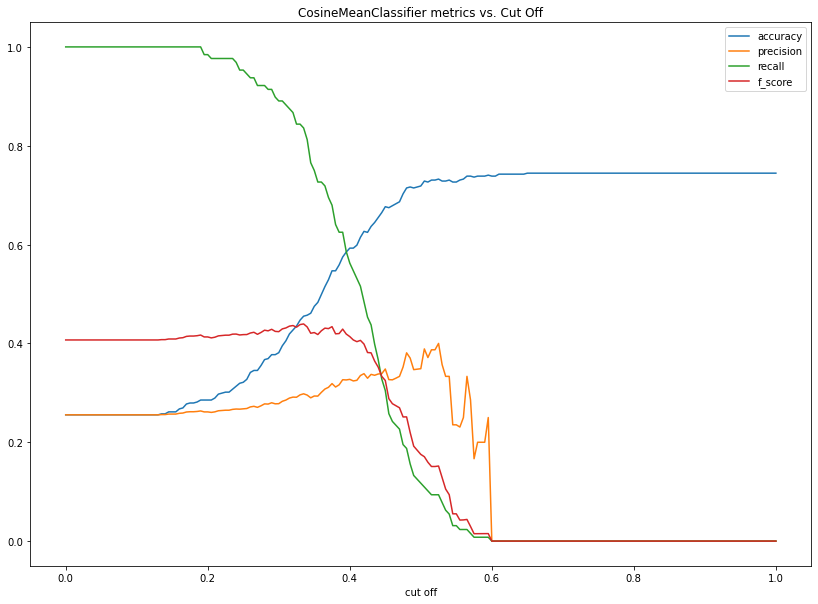

In [82]:
from pipeline.classify import CosineMeanClassifier

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline
import numpy as np

cutoffs = np.linspace(0., 1.0, 201)
data = []

# we dont need to recreate this vectorizer pipeline for each cutoff
vectorizer = Pipeline([
        ('tfidf', TfidfVectorizer(min_df=2, tokenizer = nlp, sublinear_tf = True)),
        ('svd', TruncatedSVD(n_components=50))])

# stratified sampling with indices (instead of data) and labels
train_idx, test_idx, train_labels, test_labels = train_test_split(
    df.index, df.labels, test_size=0.3, stratify=df.labels.values)

# vectorize train and test text
train = vectorizer.fit_transform(df.loc[train_idx].event_text)
test = vectorizer.fit_transform(df.loc[test_idx].event_text)

# loop through cutoffs to see accuracy
for cutoff in cutoffs:
    clf = CosineMeanClassifier(cutoff=cutoff)
    
    # fit text to find mean vector then predict given cutoff
    clf.fit(train)  # fit to training data
    predictions = clf.predict(test)  # predict on test data
    
    # append prediction scores for a given vectorisation + threshold
    # we set zero_diviosn=0 to suppress warnings when all labels are predicted to be 0 (causing zero division)
    data.append({'accuracy': metrics.accuracy_score(test_labels, predictions),
    'precision' : metrics.precision_score(test_labels, predictions, zero_division=0),
    'recall' : metrics.recall_score(test_labels, predictions, zero_division=0),
    'f_score' : metrics.f1_score(test_labels, predictions, zero_division=0)})
    
results = pd.DataFrame(data, index=cutoffs)
results.plot(figsize=(14,10), title='CosineMeanClassifier metrics vs. Cut Off',xlabel='cut off')

Load current labelled data and then vectorise with doc2vec

In [19]:
vectorize.train_doc2vec(df, save=True, tag_col='event_id', token_col='tokens')

Saving model to d2v.model


In [31]:
vectorize.get_vectors(df, load=False, tag_col='event_id', token_col='tokens', as_dataframe=True)

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
event_id,,,,,,,,,,,,,,,,,,,,,
a080918_e9_1443_annual_09_13904956_0,0.668930,-0.279778,-0.420277,-0.822890,0.402661,-0.333828,0.773596,-0.688138,-1.142054,0.899668,...,0.177100,0.919773,1.665871,-0.407081,-0.144785,-0.701109,1.430089,0.793366,0.198044,-0.038451
a080918_e9_1443_annual_09_13904956_15,0.657832,-0.641307,-0.304078,-0.186189,2.619415,1.253289,2.490877,-1.716386,0.400554,0.112352,...,-0.438933,-0.319499,-0.190034,0.077476,-0.134749,0.445385,-0.259214,-1.824174,-0.055695,-0.355211
a080918_e9_1443_annual_09_13904956_18,0.347470,-0.608776,-0.838911,-0.653656,2.306112,0.018082,0.243941,-1.898511,1.019025,2.006934,...,-1.651567,-0.531327,0.496745,-0.015744,-1.154105,0.193808,1.315309,-0.216073,-1.374814,0.078365
a080918_e9_1443_annual_09_13904956_21,-0.061630,0.440765,0.233930,-1.556354,0.714289,0.880374,0.210685,-2.664253,-0.285275,0.479279,...,-2.941750,0.627398,1.849445,-1.264933,-0.923828,-1.574953,1.696771,0.681737,1.117253,0.850647
a080918_e9_1443_annual_09_13904956_34,0.706675,-0.536254,-0.743269,-0.664670,3.541929,-1.521755,-0.214361,-2.621762,-0.490862,2.065600,...,-1.324364,0.607875,0.665061,-1.612101,2.282451,-0.942053,1.118826,0.792009,0.854093,0.433301
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
a075860_daltons e45-2186 & 2187 annual tech rep to mar 07_15101698_55,-0.126468,0.832611,-0.187676,-0.376137,-1.359864,-0.688942,1.548493,-2.300737,-0.750028,0.924462,...,-1.276662,-1.064092,1.010387,0.368638,-0.653518,-0.540286,2.829690,0.402474,0.950589,-1.981532
a075860_daltons e45-2186 & 2187 annual tech rep to mar 07_15101698_67,0.149791,-0.331744,0.161247,-1.838393,-0.865741,-2.077905,-0.004226,-1.029320,0.434331,1.442513,...,-0.334718,-0.813091,2.029144,-0.442725,0.832266,0.356118,1.051715,0.538166,1.546230,-1.745382
a075860_daltons e45-2186 & 2187 annual tech rep to mar 07_15101698_83,0.074123,0.705113,-0.558106,-0.351324,-1.921091,-1.465138,0.834385,-1.750575,-0.573122,1.355913,...,-2.435156,-1.039865,0.797037,-0.325818,-0.732299,-0.432632,1.467224,0.379203,0.207841,-0.646846


In [26]:
import numpy as np
model = vectorize.load_doc2vec()

In [51]:
filename = events_path / f'group_2_labelled.csv'
df = pd.read_csv(filename)
df = df[df.columns]
df

,event_id,filename,sentence_idx,sentence_text,n_trigger_words,trigger_words_in_sentence,trigger_words_in_event,event_text,ORE_DEPOSIT,ROCK,MINERAL,STRAT,LOCATION,TIMESCALE,event_label,reviewed,Near Miss Event,Key trigger phrase,Key trigger phrase
0,a081752_anrep2008eraheedy2103_15107355_16,a081752_anrep2008eraheedy2103_15107355.json,16,mineral occurrences and exploration potential ...,1,['potential'],['potential'],"bibliography bunting ja 1986, geology of the e...",[],['granite'],[],[],"['nabberu basin', 'western australia', 'wester...",[],0,True,False,NaN,NaN
1,a075210_buck_a_ el12_1_2007_11292066_235,a075210_buck_a_ el12_1_2007_11292066.json,235,further drilling in coming years will further ...,1,['further drilling'],['further drilling'],a summary of the coal tonnages within el12 1 i...,[],['coal'],[],[],[],[],0,True,False,NaN,NaN
2,a075210_buck_a_ el12_1_2007_11292066_246,a075210_buck_a_ el12_1_2007_11292066.json,246,the tenement was applied for on the 12 1 2005 ...,1,['possible'],['possible'],"keywords: ac drilling, diamond core drilling, ...",[],['ash'],"['diamond', 'sulphur']",[],"['muja', 'collie', 'ewington', 'collie']",[],0,True,False,NaN,NaN
3,a080379_e80_2574_08atr_12876104_4,a080379_e80_2574_08atr_12876104.json,4,the east kimberley halls creek orogen is widel...,2,"['potential', 'mineralisation']","['potential', 'mineralisation', 'broad']",if this work is positive drill testing of anom...,['pge'],[],"['gold', 'sulphide']",[],"['kimberley', 'halls creek orogen', 'australia']",[],0,True,False,NaN,NaN
4,a080379_e80_2574_08atr_12876104_10,a080379_e80_2574_08atr_12876104.json,10,this belt contains the portimo and penikat int...,2,"['mineralisation', 'potential']","['mineralisation', 'potential', 'mineralisatio...",the hco has a number of similarities to the to...,"['pge', 'pge']",[],[],[],[],[],0,True,False,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
765,a080097_microsoft word - 081110_e52_1711_parti...,a080097_microsoft word - 081110_e52_1711_parti...,30,manganese mineralisation associated with shaly...,1,['mineralisation'],"['mineralisation', 'mineralisation']",the sylvania dome and areas to the south overl...,[],[],"['diamonds', 'gold', 'manganese']",['calyie formation'],"['sylvania dome', 'bamboo']",[],0,False,NaN,NaN,NaN
766,a080097_microsoft word - 081110_e52_1711_parti...,a080097_microsoft word - 081110_e52_1711_parti...,35,the greenstones were outcropping and chip samp...,1,['extensive'],['extensive'],in all cases conductors were identified as str...,['base metal'],"['shales', 'greenstones', 'greenstones', 'quar...",['gold'],[],[],[],0,False,NaN,NaN,NaN
767,a080097_microsoft word - 081110_e52_1711_parti...,a080097_microsoft word - 081110_e52_1711_parti...,38,anaconda nickel ltd conducted a shallow rc and...,1,['potential'],"['mineralisation', 'potential']",this prospect is currently inactive due to nat...,[],"['laterite', 'laterites']",['nickel'],[],[],[],0,False,NaN,NaN,NaN
768,a080097_microsoft word - 081110_e52_1711_parti...,a080097_microsoft word - 081110_e52_1711_parti...,43,the focus of the work was to identify areas of...,2,"['potential', 'mineralisation']","['potential', 'mineralisation']",exploration exploration work completed over th...,[],['lag'],"['gold', 'gold']",[],[],[],0,False,NaN,NaN,NaN


In [52]:
df[['STRAT', 'ROCK', 'LOCATION', 'MINERAL', 'ORE_DEPOSIT', 'TIMESCALE']]

,STRAT,ROCK,LOCATION,MINERAL,ORE_DEPOSIT,TIMESCALE
0,[],['granite'],"['nabberu basin', 'western australia', 'wester...",[],[],[]
1,[],['coal'],[],[],[],[]
2,[],['ash'],"['muja', 'collie', 'ewington', 'collie']","['diamond', 'sulphur']",[],[]
3,[],[],"['kimberley', 'halls creek orogen', 'australia']","['gold', 'sulphide']",['pge'],[]
4,[],[],[],[],"['pge', 'pge']",[]
...,...,...,...,...,...,...
765,['calyie formation'],[],"['sylvania dome', 'bamboo']","['diamonds', 'gold', 'manganese']",[],[]
766,[],"['shales', 'greenstones', 'greenstones', 'quar...",[],['gold'],['base metal'],[]
767,[],"['laterite', 'laterites']",[],['nickel'],[],[]
768,[],['lag'],[],"['gold', 'gold']",[],[]


In [59]:
df.index.to_frame()

,0
0,0
1,1
2,2
3,3
4,4
...,...
765,765
766,766
767,767
768,768


In [65]:
df.loc[0,'ROCK']

"['granite']"

In [62]:
def get_onehot_features(df):
    from sklearn.preprocessing import MultiLabelBinarizer
    mlb = MultiLabelBinarizer()

    # temp func
    def to_list(x):
        if isinstance(x, str):
            return x.split(',')
        else:
            return ['unknown']
        
    frames = []
    for feature in ['STRAT', 'ROCK', 'LOCATION', 'MINERAL', 'ORE_DEPOSIT', 'TIMESCALE']:
        s = df[feature].apply(to_list)
        wide_df = pd.DataFrame(mlb.fit_transform(s), columns=mlb.classes_, index=df.index)
        wide_df = wide_df.add_prefix(f'{feature}_')
        frames.append(wide_df)
    return pd.concat(frames)

In [63]:
get_onehot_features(df)

,STRAT_ 'bangemall group'],STRAT_ 'biscay formation'],STRAT_ 'brockman iron formation',STRAT_ 'brockman iron formation'],STRAT_ 'buldania granitoid complex'],STRAT_ 'burt range formation',STRAT_ 'burt range formation'],STRAT_ 'buttons formation',STRAT_ 'buttons formation'],STRAT_ 'corunna downs granitoid complex'],...,TIMESCALE_['phanerozoic'],TIMESCALE_['pleistocene',TIMESCALE_['pleistocene'],TIMESCALE_['precambrian',TIMESCALE_['proterozoic',TIMESCALE_['proterozoic'],TIMESCALE_['tertiary',TIMESCALE_['tertiary'],TIMESCALE_['tournaisian'],TIMESCALE_[]
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
765,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
766,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
767,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
768,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
